In [1]:
import numpy as np

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 7장 요약
- CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
- 합성곱 계층과 풀링 계층은 im2col(이미지를 행렬로 전개하는 함수)를 이용하면 간단하고 효율적으로 구현할 수 있다.
- CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
- 대표적인 CNN에는 LeNet과 AlexNet이 있다.
- 딥러닝의 발전에는 빅데이터와 GPU가 크게 기여했다.

# 7.4 합성곱/풀링 계층 구현하기

## 7.4.1 4차원 배열

In [2]:
# 높이 28, 너비 28, 채널 1, 데이터 10개 
x = np.random.rand(10, 1, 28, 28) # 무작위로 데이터 생성
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape
x[1].shape

(1, 28, 28)

(1, 28, 28)

In [4]:
# 첫 번째 데이터의 첫 채널의 공간 데이터에 접근하려면..
x[0, 0] # 또는 x[0][0]
x[0, 0].shape

array([[0.52530785, 0.48357026, 0.16381552, 0.12437107, 0.10131926,
        0.8157932 , 0.98286363, 0.88500081, 0.4576055 , 0.28428154,
        0.51006138, 0.45152343, 0.23207219, 0.4308031 , 0.30000799,
        0.40272487, 0.53607306, 0.8289756 , 0.80965548, 0.22783321,
        0.96822233, 0.35632697, 0.39011858, 0.11847098, 0.53932076,
        0.22983528, 0.383671  , 0.59791698],
       [0.39412843, 0.95878339, 0.69463755, 0.46191315, 0.14481719,
        0.92695384, 0.97386371, 0.22897346, 0.16305979, 0.26551019,
        0.88941237, 0.47315746, 0.279143  , 0.48118535, 0.35885748,
        0.18885421, 0.89522352, 0.63153274, 0.10238458, 0.50014023,
        0.40803037, 0.11207046, 0.32267511, 0.86661103, 0.46397652,
        0.87671893, 0.6293086 , 0.01986102],
       [0.42593745, 0.02962822, 0.06716828, 0.88665643, 0.0099883 ,
        0.43057629, 0.15182241, 0.29826811, 0.89632236, 0.60760909,
        0.20854758, 0.0046952 , 0.37331096, 0.21371273, 0.48520763,
        0.22666127, 0.5599

(28, 28)

## 7.4.3 합성곱 계층 구현하기

In [5]:
im2col(input_data, filter_h, filter_w, stride=1, pad=0)

NameError: name 'im2col' is not defined

In [ ]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [ ]:
class Convolution:
    # W : Weight => 가중치, 필터
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int((H + 2*self.pad - FH)/self.stride + 1)
        out_w = int((W + 2*self.pad - FW)/self.stride + 1)

        # 입력 데이터를 im2col로 전개
        col = im2col(x, FH, FW, self.stride, self.pad)
        
        # 필터도 reshape을 사용해 2차원 배열로 전개
        col_W = self.W.reshape(FN, -1).T

        # 이렇게 전개한 두 행렬의 곱을 구함
        out = np.dot(col, col_W) + self.b

        # 출력 데이터를 적절한 형상으로 바꿔줌
        # (N, C, OH, OW)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

## 7.4.4 풀링 계층 구현하기

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int((H - self.pool_h)/self.stride + 1)
        out_w = int((W - self.pool_w)/self.stride + 1)

        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값 (2)
        out = np.max(col, axis=1)

        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

# 7.5 CNN 구현하기

In [ ]:
class SimpleConvNet:

    # 초기화를 수행하는 메서드
    def __init__(self, input_dim=(1,28,28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                hidden_size=100, ouput_size=10, weight_init_std=0.01):
                
                # 초기화 인수로 주어진 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼냄
                filter_num = conv_param['filter_num']
                filter_size = conv_param['filter_size']
                filter_pad = conv_param['pad']
                filter_stride = conv_param['stride']
                input_size = input_dim[1]

                # 합성곱 계층의 출력 크기를 계산
                conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
                pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
                
                # 가중치 매개변수를 초기화 
                self.params = {}
                # W1, b1 : 1번째 층의 합성곱 계층의 가중치와 편향
                self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
                self.params['b1'] = np.zeros(filter_num)
                # W2, b2 : 2번째 층의 완전연결계층의 가중치와 편향 
                self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
                self.params['b2'] = np.zeros(hidden_size)
                # W3, b3 : 마지막 3번째 층의 완전연결계층의 가중치와 편향 
                self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
                self.params['b3'] = np.zeros(output_size)

                # 순서가 있는 딕셔너리인 layers에 계층들을 차례로 추가
                self.layers = OrderedDict()
                self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
                self.layers['Relu1'] = Relu()
                self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
                self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
                self.layers['Relu2'] = Relu()
                self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
                
                # SoftmaxWithLoss 계층만큼은 last_layer라는 별도 변수에 저장 
                self.last_layer = SoftmaxWithLoss()

    # 추론을 수행하는 predict 메서드
    def predict(self, x):
        # 초기화 때 layers에 추가한 계층을 맨 앞에서부터 차례로 forward 메서드를 호출하며 그 결과를 다음 계층에 전달함
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # 손실 함수의 값을 구하는 loss 메서드
    # x : 입력 데이터, t : 정답 레이블
    # 손실 함수를 구하는 loss 메서드는 predict 메서드의 결과를 인수로 마지막 층의 forward 메서드를 호출함
    # 즉, 첫 계층부터 마지막 계층까지 forward를 처리함
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.2999515418800307
=== epoch:1, train acc:0.1, test acc:0.108 ===
train loss:2.2969701317977465
train loss:2.2939551886298295
train loss:2.287394698202645
train loss:2.275757792832552
train loss:2.2704508894129747
train loss:2.2419736107870194
train loss:2.225844784933764
train loss:2.206772419331863
train loss:2.1694306995389803
train loss:2.1529175114317325
train loss:2.103916663216195
train loss:2.0575191588022737
train loss:2.0441282477732674
train loss:2.022529129185105
train loss:1.928530887903033
train loss:1.8331397620375618
train loss:1.7262628021840905
train loss:1.7147155831416532
train loss:1.6521625646013365
train loss:1.4784732509453473
train loss:1.3840572179594555
train loss:1.4354632183

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'accuracy')

(0.0, 1.0)

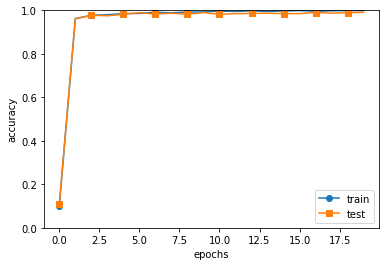

In [6]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()